In [1]:
import pandas as pd

In [2]:
df=pd.read_csv('/kaggle/input/new-data-2/new_data_2.csv')

In [3]:
df.head()

,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,...,y30,x31,y31,x32,y32,x33,y33,x34,y34,target
0,0.476535,0.366498,0.476804,0.359319,0.475738,0.358378,0.474682,0.357341,0.474839,0.359071,...,0.635365,0.418692,0.608916,0.388385,0.641650,0.000000,0.000000,0.000000,0.000000,1
1,0.474410,0.397083,0.473103,0.391008,0.472416,0.390489,0.472051,0.389991,0.470423,0.391237,...,0.625212,0.437651,0.612700,0.423325,0.628663,0.457407,0.514062,0.580556,0.630729,1
2,0.339507,0.293347,0.332266,0.288797,0.327988,0.289112,0.323918,0.289463,0.344367,0.288060,...,0.651801,0.368331,0.605753,0.404012,0.639864,0.223148,0.311458,0.594444,0.494792,9
3,0.430899,0.387932,0.432586,0.379750,0.430481,0.378213,0.428413,0.376827,0.435235,0.381818,...,0.689175,0.378882,0.650294,0.348221,0.694410,0.434259,0.481771,0.668519,0.597917,6
4,0.490887,0.364345,0.490853,0.355861,0.490024,0.354849,0.489299,0.353818,0.488503,0.356390,...,0.692504,0.439184,0.646042,0.413528,0.692971,0.494444,0.530729,0.704630,0.676042,0


In [4]:
df.columns

Index(['x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'x5', 'y5',
       'x6', 'y6', 'x7', 'y7', 'x8', 'y8', 'x9', 'y9', 'x10', 'y10', 'x11',
       'y11', 'x12', 'y12', 'x13', 'y13', 'x14', 'y14', 'x15', 'y15', 'x16',
       'y16', 'x17', 'y17', 'x18', 'y18', 'x19', 'y19', 'x20', 'y20', 'x21',
       'y21', 'x22', 'y22', 'x23', 'y23', 'x24', 'y24', 'x25', 'y25', 'x26',
       'y26', 'x27', 'y27', 'x28', 'y28', 'x29', 'y29', 'x30', 'y30', 'x31',
       'y31', 'x32', 'y32', 'x33', 'y33', 'x34', 'y34', 'target'],
      dtype='object')

In [46]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import joblib



In [47]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tqdm import tqdm
import joblib


In [48]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit_transform(df['target'])

array([1, 1, 9, ..., 6, 0, 0])

In [49]:

# ---------------------------------------------------
# Data Preparation
# ---------------------------------------------------

class GolfPoseDataset(Dataset):
    def __init__(self, df, seq_len=None):
        self.seq_len = seq_len
        self.features = df.drop('target', axis=1).values.astype(np.float32)
        self.targets = df['target'].values.astype(np.int64)
        self.sequences = self._create_sequences()
    
    def _create_sequences(self):
        sequences = []
        data_len = len(self.features)
        if self.seq_len is None:
            # Treat the entire data as one sequence
            sequences.append((self.features, self.targets))
        else:
            # Split data into sequences of length seq_len
            for i in range(0, data_len, self.seq_len):
                seq_features = self.features[i:i + self.seq_len]
                seq_targets = self.targets[i:i + self.seq_len]
                sequences.append((seq_features, seq_targets))
        return sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq_features, seq_targets = self.sequences[idx]
        return torch.tensor(seq_features, dtype=torch.float32), torch.tensor(seq_targets, dtype=torch.long)



In [81]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, fc_hidden_sizes=None):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            bidirectional=True,
                            batch_first=True)
        
        # Define the fully connected layers after LSTM
        if fc_hidden_sizes is None:
            fc_hidden_sizes = []
        
        fc_layers = []
        input_dim = hidden_size * 2  # Because LSTM is bidirectional
        
        # Create FC layers dynamically based on fc_hidden_sizes
        for fc_hidden_size in fc_hidden_sizes:
            fc_layers.append(nn.Linear(input_dim, fc_hidden_size))
            fc_layers.append(nn.ReLU())
            input_dim = fc_hidden_size  # Update input_dim for the next layer
        
        # Final output layer
        fc_layers.append(nn.Linear(input_dim, output_size))
        self.fc = nn.Sequential(*fc_layers)
    
    def forward(self, x, seq_lengths):
        # Pack the padded sequence
        x_packed = nn.utils.rnn.pack_padded_sequence(x, seq_lengths.cpu(), batch_first=True, enforce_sorted=False)
        # Pass through LSTM
        out_packed, _ = self.lstm(x_packed)
        # Unpack the sequence
        out, _ = nn.utils.rnn.pad_packed_sequence(out_packed, batch_first=True)
        # Pass through the fully connected layers
        out = self.fc(out)
        return out


In [82]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    for sequences, labels, seq_lengths in tqdm(train_loader, desc='Training'):
        sequences = sequences.to(device)
        labels = labels.to(device)
        # seq_lengths should remain on CPU
        seq_lengths = torch.tensor(seq_lengths, dtype=torch.long)  # Remove .to(device)
        optimizer.zero_grad()
        outputs = model(sequences, seq_lengths)
        outputs = outputs.view(-1, outputs.size(-1))
        labels = labels.view(-1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * sequences.size(0)
        _, preds = torch.max(outputs, 1)
        # Filter out the padded positions
        valid_indices = labels != -100
        all_preds.extend(preds[valid_indices].cpu().numpy())
        all_labels.extend(labels[valid_indices].cpu().numpy())
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = accuracy_score(all_labels, all_preds)
    epoch_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    epoch_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    return epoch_loss, epoch_accuracy, epoch_precision, epoch_recall, epoch_f1


In [83]:
def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for sequences, labels, seq_lengths in tqdm(val_loader, desc='Validation'):
            sequences = sequences.to(device)
            labels = labels.to(device)
            # seq_lengths should remain on CPU
            seq_lengths = torch.tensor(seq_lengths, dtype=torch.long)  # Remove .to(device)
            outputs = model(sequences, seq_lengths)
            outputs = outputs.view(-1, outputs.size(-1))
            labels = labels.view(-1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * sequences.size(0)
            _, preds = torch.max(outputs, 1)
            # Filter out the padded positions
            valid_indices = labels != -100
            all_preds.extend(preds[valid_indices].cpu().numpy())
            all_labels.extend(labels[valid_indices].cpu().numpy())
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = accuracy_score(all_labels, all_preds)
    epoch_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    epoch_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    return epoch_loss, epoch_accuracy, epoch_precision, epoch_recall, epoch_f1


In [84]:

# Load your DataFrame
df = pd.read_csv('/kaggle/input/new-data-2/new_data_2.csv')  # Replace with your training data file

# Ensure 'target' column is of integer type
df['target'] = df['target'].astype(int)

# Features are from 'x0' to 'x33', target is 'target' (34 features)
feature_columns = df.columns.drop('target')

# Data normalization/scaling
scaler = StandardScaler()
df[feature_columns] = scaler.fit_transform(df[feature_columns])

# Save the scaler for later use
joblib.dump(scaler, 'scaler.save')

# Create the dataset
seq_len = 100  # Set to desired sequence length
dataset = GolfPoseDataset(df, seq_len=seq_len)

# Check dataset length
print(f"Number of sequences in dataset: {len(dataset)}")



Number of sequences in dataset: 56


In [85]:
def collate_fn(batch):
    sequences, labels = zip(*batch)
    seq_lengths = [len(seq) for seq in sequences]
    # Find the maximum sequence length in the batch
    max_len = max(seq_lengths)
    # Pad sequences and labels
    padded_sequences = []
    padded_labels = []
    for seq, label in zip(sequences, labels):
        seq_len = seq.shape[0]
        pad_size = max_len - seq_len
        # Pad sequences with zeros (for features)
        seq_padded = torch.nn.functional.pad(seq, (0, 0, 0, pad_size))  # Pads on the bottom
        padded_sequences.append(seq_padded)
        # Pad labels with -100 (ignore index for loss)
        label_padded = torch.nn.functional.pad(label, (0, pad_size), value=-100)
        padded_labels.append(label_padded)
    # Stack sequences and labels
    padded_sequences = torch.stack(padded_sequences)
    padded_labels = torch.stack(padded_labels)
    return padded_sequences, padded_labels, seq_lengths


In [86]:
# Proceed with train/test split
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Ensure that train_size and val_size are at least 1
if train_size == 0 and len(dataset) > 1:
    train_size = 1
    val_size = len(dataset) - train_size
elif val_size == 0 and len(dataset) > 1:
    val_size = 1
    train_size = len(dataset) - val_size
elif len(dataset) == 1:
    train_size = 1
    val_size = 0

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

batch_size = 2  # Set batch size as desired
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


In [87]:
# ---------------------------------------------------
# Execution
# ---------------------------------------------------
# Define model parameters
input_size = len(feature_columns)         # Number of input features per time step
hidden_size = 512                  # Size of hidden state in LSTM
num_layers = 2                   # Number of LSTM layers
output_size = df['target'].nunique()      # Number of output classes
# Example: Adding two FC layers with 128 and 64 units
fc_hidden_sizes = [128, 64]
model = BiLSTMModel(input_size, hidden_size, num_layers, output_size, fc_hidden_sizes=fc_hidden_sizes)


# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)



BiLSTMModel(
  (lstm): LSTM(70, 512, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [79]:
# Set label_smoothing=0.0 explicitly
criterion = nn.CrossEntropyLoss(ignore_index=-100, label_smoothing=0.0)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 100  # Adjust as needed
for epoch in range(num_epochs):
    # Training
    train_loss, train_acc, train_prec, train_rec, train_f1 = train_model(
        model, train_loader, criterion, optimizer, device)
    # Validation
    val_loss, val_acc, val_prec, val_rec, val_f1 = evaluate_model(
        model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc*100:.2f}%, "
          f"Precision: {train_prec:.4f}, Recall: {train_rec:.4f}, F1 Score: {train_f1:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_acc*100:.2f}%, "
          f"Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, F1 Score: {val_f1:.4f}")
    print('-' * 60)

# Save the trained model
torch.save(model.state_dict(), 'bilstm_pose_model.pth')
print("Model training complete and saved.")


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.10it/s]


Epoch 1/100:
Train Loss: 2.2102, Accuracy: 26.74%, Precision: 0.1664, Recall: 0.2674, F1 Score: 0.1468
Val Loss: 2.0966, Accuracy: 28.33%, Precision: 0.2248, Recall: 0.2833, F1 Score: 0.1652
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.38it/s]


Epoch 2/100:
Train Loss: 2.0000, Accuracy: 29.38%, Precision: 0.1841, Recall: 0.2938, F1 Score: 0.1704
Val Loss: 1.8590, Accuracy: 36.50%, Precision: 0.2359, Recall: 0.3650, F1 Score: 0.2534
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 101.01it/s]


Epoch 3/100:
Train Loss: 1.6662, Accuracy: 41.57%, Precision: 0.3454, Recall: 0.4157, F1 Score: 0.3188
Val Loss: 1.3985, Accuracy: 52.50%, Precision: 0.5287, Recall: 0.5250, F1 Score: 0.4931
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 104.17it/s]


Epoch 4/100:
Train Loss: 1.2399, Accuracy: 53.80%, Precision: 0.5091, Recall: 0.5380, F1 Score: 0.4944
Val Loss: 1.0804, Accuracy: 60.67%, Precision: 0.6198, Recall: 0.6067, F1 Score: 0.5711
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 104.50it/s]


Epoch 5/100:
Train Loss: 1.0162, Accuracy: 60.54%, Precision: 0.5802, Recall: 0.6054, F1 Score: 0.5726
Val Loss: 0.9252, Accuracy: 65.83%, Precision: 0.6521, Recall: 0.6583, F1 Score: 0.6385
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.27it/s]


Epoch 6/100:
Train Loss: 0.8982, Accuracy: 65.08%, Precision: 0.6373, Recall: 0.6508, F1 Score: 0.6290
Val Loss: 0.8404, Accuracy: 69.00%, Precision: 0.7027, Recall: 0.6900, F1 Score: 0.6696
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.28it/s]


Epoch 7/100:
Train Loss: 0.8255, Accuracy: 67.64%, Precision: 0.6612, Recall: 0.6764, F1 Score: 0.6563
Val Loss: 0.7946, Accuracy: 69.67%, Precision: 0.6870, Recall: 0.6967, F1 Score: 0.6856
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.02it/s]


Epoch 8/100:
Train Loss: 0.7755, Accuracy: 69.55%, Precision: 0.6829, Recall: 0.6955, F1 Score: 0.6788
Val Loss: 0.7586, Accuracy: 69.50%, Precision: 0.6862, Recall: 0.6950, F1 Score: 0.6867
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 104.57it/s]


Epoch 9/100:
Train Loss: 0.7393, Accuracy: 70.74%, Precision: 0.6956, Recall: 0.7074, F1 Score: 0.6939
Val Loss: 0.7283, Accuracy: 70.33%, Precision: 0.6928, Recall: 0.7033, F1 Score: 0.6939
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.85it/s]


Epoch 10/100:
Train Loss: 0.7071, Accuracy: 72.08%, Precision: 0.7109, Recall: 0.7208, F1 Score: 0.7091
Val Loss: 0.7111, Accuracy: 70.00%, Precision: 0.6908, Recall: 0.7000, F1 Score: 0.6911
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 101.71it/s]


Epoch 11/100:
Train Loss: 0.6770, Accuracy: 73.28%, Precision: 0.7246, Recall: 0.7328, F1 Score: 0.7232
Val Loss: 0.6947, Accuracy: 71.17%, Precision: 0.7046, Recall: 0.7117, F1 Score: 0.7057
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.48it/s]


Epoch 12/100:
Train Loss: 0.6509, Accuracy: 74.13%, Precision: 0.7337, Recall: 0.7413, F1 Score: 0.7327
Val Loss: 0.6821, Accuracy: 71.50%, Precision: 0.7077, Recall: 0.7150, F1 Score: 0.7095
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 105.35it/s]


Epoch 13/100:
Train Loss: 0.6280, Accuracy: 75.25%, Precision: 0.7459, Recall: 0.7525, F1 Score: 0.7447
Val Loss: 0.6725, Accuracy: 72.67%, Precision: 0.7192, Recall: 0.7267, F1 Score: 0.7209
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 104.62it/s]


Epoch 14/100:
Train Loss: 0.6063, Accuracy: 76.22%, Precision: 0.7560, Recall: 0.7622, F1 Score: 0.7553
Val Loss: 0.6654, Accuracy: 73.17%, Precision: 0.7244, Recall: 0.7317, F1 Score: 0.7259
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 105.40it/s]


Epoch 15/100:
Train Loss: 0.5849, Accuracy: 77.36%, Precision: 0.7680, Recall: 0.7736, F1 Score: 0.7672
Val Loss: 0.6600, Accuracy: 73.50%, Precision: 0.7282, Recall: 0.7350, F1 Score: 0.7295
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 105.18it/s]


Epoch 16/100:
Train Loss: 0.5638, Accuracy: 78.37%, Precision: 0.7788, Recall: 0.7837, F1 Score: 0.7781
Val Loss: 0.6559, Accuracy: 73.67%, Precision: 0.7316, Recall: 0.7367, F1 Score: 0.7320
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.10it/s]


Epoch 17/100:
Train Loss: 0.5428, Accuracy: 79.43%, Precision: 0.7894, Recall: 0.7943, F1 Score: 0.7891
Val Loss: 0.6529, Accuracy: 74.00%, Precision: 0.7349, Recall: 0.7400, F1 Score: 0.7352
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.00it/s]


Epoch 18/100:
Train Loss: 0.5215, Accuracy: 80.83%, Precision: 0.8040, Recall: 0.8083, F1 Score: 0.8041
Val Loss: 0.6513, Accuracy: 73.83%, Precision: 0.7346, Recall: 0.7383, F1 Score: 0.7341
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 104.37it/s]


Epoch 19/100:
Train Loss: 0.5002, Accuracy: 81.90%, Precision: 0.8154, Recall: 0.8190, F1 Score: 0.8155
Val Loss: 0.6505, Accuracy: 73.50%, Precision: 0.7302, Recall: 0.7350, F1 Score: 0.7306
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.24it/s]


Epoch 20/100:
Train Loss: 0.4786, Accuracy: 82.76%, Precision: 0.8247, Recall: 0.8276, F1 Score: 0.8247
Val Loss: 0.6502, Accuracy: 73.17%, Precision: 0.7267, Recall: 0.7317, F1 Score: 0.7276
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.62it/s]


Epoch 21/100:
Train Loss: 0.4567, Accuracy: 83.83%, Precision: 0.8358, Recall: 0.8383, F1 Score: 0.8357
Val Loss: 0.6513, Accuracy: 73.33%, Precision: 0.7308, Recall: 0.7333, F1 Score: 0.7299
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.24it/s]


Epoch 22/100:
Train Loss: 0.4348, Accuracy: 85.09%, Precision: 0.8489, Recall: 0.8509, F1 Score: 0.8488
Val Loss: 0.6542, Accuracy: 74.17%, Precision: 0.7394, Recall: 0.7417, F1 Score: 0.7384
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 104.45it/s]


Epoch 23/100:
Train Loss: 0.4141, Accuracy: 86.24%, Precision: 0.8607, Recall: 0.8624, F1 Score: 0.8607
Val Loss: 0.6581, Accuracy: 73.67%, Precision: 0.7362, Recall: 0.7367, F1 Score: 0.7339
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.84it/s]


Epoch 24/100:
Train Loss: 0.3964, Accuracy: 87.30%, Precision: 0.8716, Recall: 0.8730, F1 Score: 0.8715
Val Loss: 0.6591, Accuracy: 74.67%, Precision: 0.7480, Recall: 0.7467, F1 Score: 0.7444
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 104.74it/s]


Epoch 25/100:
Train Loss: 0.3847, Accuracy: 87.32%, Precision: 0.8717, Recall: 0.8732, F1 Score: 0.8717
Val Loss: 0.6706, Accuracy: 73.83%, Precision: 0.7425, Recall: 0.7383, F1 Score: 0.7337
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 104.51it/s]


Epoch 26/100:
Train Loss: 0.3751, Accuracy: 88.17%, Precision: 0.8803, Recall: 0.8817, F1 Score: 0.8804
Val Loss: 0.6743, Accuracy: 73.83%, Precision: 0.7415, Recall: 0.7383, F1 Score: 0.7330
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 104.35it/s]


Epoch 27/100:
Train Loss: 0.3607, Accuracy: 88.56%, Precision: 0.8843, Recall: 0.8856, F1 Score: 0.8838
Val Loss: 0.6562, Accuracy: 74.00%, Precision: 0.7402, Recall: 0.7400, F1 Score: 0.7346
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.61it/s]


Epoch 28/100:
Train Loss: 0.3295, Accuracy: 90.18%, Precision: 0.9007, Recall: 0.9018, F1 Score: 0.9009
Val Loss: 0.6686, Accuracy: 73.83%, Precision: 0.7335, Recall: 0.7383, F1 Score: 0.7243
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 104.14it/s]


Epoch 29/100:
Train Loss: 0.3086, Accuracy: 91.46%, Precision: 0.9139, Recall: 0.9146, F1 Score: 0.9139
Val Loss: 0.6656, Accuracy: 72.83%, Precision: 0.7215, Recall: 0.7283, F1 Score: 0.7200
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 102.02it/s]


Epoch 30/100:
Train Loss: 0.2928, Accuracy: 91.95%, Precision: 0.9189, Recall: 0.9195, F1 Score: 0.9188
Val Loss: 0.6690, Accuracy: 71.83%, Precision: 0.7095, Recall: 0.7183, F1 Score: 0.7101
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 104.12it/s]


Epoch 31/100:
Train Loss: 0.2745, Accuracy: 92.51%, Precision: 0.9245, Recall: 0.9251, F1 Score: 0.9245
Val Loss: 0.6779, Accuracy: 74.00%, Precision: 0.7460, Recall: 0.7400, F1 Score: 0.7314
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 102.21it/s]


Epoch 32/100:
Train Loss: 0.2559, Accuracy: 94.08%, Precision: 0.9405, Recall: 0.9408, F1 Score: 0.9404
Val Loss: 0.6941, Accuracy: 73.17%, Precision: 0.7323, Recall: 0.7317, F1 Score: 0.7218
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.40it/s]


Epoch 33/100:
Train Loss: 0.2461, Accuracy: 94.14%, Precision: 0.9413, Recall: 0.9414, F1 Score: 0.9411
Val Loss: 0.7030, Accuracy: 74.00%, Precision: 0.7322, Recall: 0.7400, F1 Score: 0.7232
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 102.51it/s]


Epoch 34/100:
Train Loss: 0.2383, Accuracy: 93.63%, Precision: 0.9361, Recall: 0.9363, F1 Score: 0.9360
Val Loss: 0.6754, Accuracy: 73.50%, Precision: 0.7345, Recall: 0.7350, F1 Score: 0.7334
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.68it/s]


Epoch 35/100:
Train Loss: 0.2152, Accuracy: 94.87%, Precision: 0.9483, Recall: 0.9487, F1 Score: 0.9483
Val Loss: 0.7312, Accuracy: 73.00%, Precision: 0.7425, Recall: 0.7300, F1 Score: 0.7321
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 104.03it/s]


Epoch 36/100:
Train Loss: 0.1906, Accuracy: 96.35%, Precision: 0.9635, Recall: 0.9635, F1 Score: 0.9633
Val Loss: 0.7063, Accuracy: 74.00%, Precision: 0.7436, Recall: 0.7400, F1 Score: 0.7393
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 104.51it/s]


Epoch 37/100:
Train Loss: 0.1805, Accuracy: 96.61%, Precision: 0.9660, Recall: 0.9661, F1 Score: 0.9661
Val Loss: 0.7445, Accuracy: 72.33%, Precision: 0.7299, Recall: 0.7233, F1 Score: 0.7128
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.19it/s]


Epoch 38/100:
Train Loss: 0.1685, Accuracy: 97.04%, Precision: 0.9703, Recall: 0.9704, F1 Score: 0.9703
Val Loss: 0.7516, Accuracy: 71.67%, Precision: 0.7341, Recall: 0.7167, F1 Score: 0.7123
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 101.82it/s]


Epoch 39/100:
Train Loss: 0.1498, Accuracy: 97.83%, Precision: 0.9783, Recall: 0.9783, F1 Score: 0.9782
Val Loss: 0.7123, Accuracy: 74.00%, Precision: 0.7444, Recall: 0.7400, F1 Score: 0.7388
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 102.07it/s]


Epoch 40/100:
Train Loss: 0.1294, Accuracy: 98.52%, Precision: 0.9852, Recall: 0.9852, F1 Score: 0.9852
Val Loss: 0.7205, Accuracy: 73.33%, Precision: 0.7295, Recall: 0.7333, F1 Score: 0.7277
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.92it/s]


Epoch 41/100:
Train Loss: 0.1137, Accuracy: 99.05%, Precision: 0.9905, Recall: 0.9905, F1 Score: 0.9905
Val Loss: 0.7266, Accuracy: 74.83%, Precision: 0.7518, Recall: 0.7483, F1 Score: 0.7469
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.88it/s]


Epoch 42/100:
Train Loss: 0.0988, Accuracy: 99.43%, Precision: 0.9943, Recall: 0.9943, F1 Score: 0.9943
Val Loss: 0.7464, Accuracy: 74.00%, Precision: 0.7447, Recall: 0.7400, F1 Score: 0.7385
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.21it/s]


Epoch 43/100:
Train Loss: 0.0902, Accuracy: 99.49%, Precision: 0.9949, Recall: 0.9949, F1 Score: 0.9949
Val Loss: 0.7444, Accuracy: 73.17%, Precision: 0.7330, Recall: 0.7317, F1 Score: 0.7299
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.92it/s]


Epoch 44/100:
Train Loss: 0.0813, Accuracy: 99.57%, Precision: 0.9957, Recall: 0.9957, F1 Score: 0.9957
Val Loss: 0.7466, Accuracy: 74.17%, Precision: 0.7407, Recall: 0.7417, F1 Score: 0.7387
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 102.68it/s]


Epoch 45/100:
Train Loss: 0.0748, Accuracy: 99.72%, Precision: 0.9972, Recall: 0.9972, F1 Score: 0.9972
Val Loss: 0.7690, Accuracy: 74.17%, Precision: 0.7471, Recall: 0.7417, F1 Score: 0.7398
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 104.96it/s]


Epoch 46/100:
Train Loss: 0.0694, Accuracy: 99.76%, Precision: 0.9976, Recall: 0.9976, F1 Score: 0.9976
Val Loss: 0.7722, Accuracy: 74.00%, Precision: 0.7391, Recall: 0.7400, F1 Score: 0.7391
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.12it/s]


Epoch 47/100:
Train Loss: 0.0650, Accuracy: 99.72%, Precision: 0.9972, Recall: 0.9972, F1 Score: 0.9972
Val Loss: 0.7808, Accuracy: 74.00%, Precision: 0.7361, Recall: 0.7400, F1 Score: 0.7359
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 102.21it/s]


Epoch 48/100:
Train Loss: 0.0614, Accuracy: 99.74%, Precision: 0.9974, Recall: 0.9974, F1 Score: 0.9974
Val Loss: 0.7951, Accuracy: 73.67%, Precision: 0.7435, Recall: 0.7367, F1 Score: 0.7365
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.83it/s]


Epoch 49/100:
Train Loss: 0.0581, Accuracy: 99.82%, Precision: 0.9982, Recall: 0.9982, F1 Score: 0.9982
Val Loss: 0.8184, Accuracy: 71.67%, Precision: 0.7281, Recall: 0.7167, F1 Score: 0.7178
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 102.93it/s]


Epoch 50/100:
Train Loss: 0.0563, Accuracy: 99.72%, Precision: 0.9972, Recall: 0.9972, F1 Score: 0.9972
Val Loss: 0.8185, Accuracy: 72.17%, Precision: 0.7218, Recall: 0.7217, F1 Score: 0.7179
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 104.57it/s]


Epoch 51/100:
Train Loss: 0.0542, Accuracy: 99.66%, Precision: 0.9966, Recall: 0.9966, F1 Score: 0.9966
Val Loss: 0.8182, Accuracy: 73.50%, Precision: 0.7419, Recall: 0.7350, F1 Score: 0.7348
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 104.05it/s]


Epoch 52/100:
Train Loss: 0.0512, Accuracy: 99.80%, Precision: 0.9980, Recall: 0.9980, F1 Score: 0.9980
Val Loss: 0.8383, Accuracy: 72.50%, Precision: 0.7331, Recall: 0.7250, F1 Score: 0.7258
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 104.62it/s]


Epoch 53/100:
Train Loss: 0.0465, Accuracy: 99.82%, Precision: 0.9982, Recall: 0.9982, F1 Score: 0.9982
Val Loss: 0.8560, Accuracy: 72.67%, Precision: 0.7327, Recall: 0.7267, F1 Score: 0.7243
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 104.26it/s]


Epoch 54/100:
Train Loss: 0.0459, Accuracy: 99.80%, Precision: 0.9980, Recall: 0.9980, F1 Score: 0.9980
Val Loss: 0.8634, Accuracy: 72.67%, Precision: 0.7375, Recall: 0.7267, F1 Score: 0.7266
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 104.38it/s]


Epoch 55/100:
Train Loss: 0.0411, Accuracy: 99.90%, Precision: 0.9990, Recall: 0.9990, F1 Score: 0.9990
Val Loss: 0.8603, Accuracy: 72.67%, Precision: 0.7342, Recall: 0.7267, F1 Score: 0.7261
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 104.28it/s]


Epoch 56/100:
Train Loss: 0.0362, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.8657, Accuracy: 74.33%, Precision: 0.7495, Recall: 0.7433, F1 Score: 0.7421
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 104.11it/s]


Epoch 57/100:
Train Loss: 0.0337, Accuracy: 99.96%, Precision: 0.9996, Recall: 0.9996, F1 Score: 0.9996
Val Loss: 0.8445, Accuracy: 73.50%, Precision: 0.7399, Recall: 0.7350, F1 Score: 0.7335
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 104.12it/s]


Epoch 58/100:
Train Loss: 0.0300, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.8676, Accuracy: 73.83%, Precision: 0.7427, Recall: 0.7383, F1 Score: 0.7349
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.84it/s]


Epoch 59/100:
Train Loss: 0.0287, Accuracy: 99.96%, Precision: 0.9996, Recall: 0.9996, F1 Score: 0.9996
Val Loss: 0.8753, Accuracy: 73.50%, Precision: 0.7416, Recall: 0.7350, F1 Score: 0.7330
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 102.71it/s]


Epoch 60/100:
Train Loss: 0.0278, Accuracy: 99.98%, Precision: 0.9998, Recall: 0.9998, F1 Score: 0.9998
Val Loss: 0.8976, Accuracy: 72.50%, Precision: 0.7310, Recall: 0.7250, F1 Score: 0.7219
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 104.88it/s]


Epoch 61/100:
Train Loss: 0.0271, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.8960, Accuracy: 73.17%, Precision: 0.7392, Recall: 0.7317, F1 Score: 0.7295
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 104.19it/s]


Epoch 62/100:
Train Loss: 0.0267, Accuracy: 99.98%, Precision: 0.9998, Recall: 0.9998, F1 Score: 0.9998
Val Loss: 0.8770, Accuracy: 72.50%, Precision: 0.7310, Recall: 0.7250, F1 Score: 0.7243
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 102.26it/s]


Epoch 63/100:
Train Loss: 0.0261, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.8700, Accuracy: 73.17%, Precision: 0.7393, Recall: 0.7317, F1 Score: 0.7323
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 104.00it/s]


Epoch 64/100:
Train Loss: 0.0248, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.8872, Accuracy: 73.00%, Precision: 0.7385, Recall: 0.7300, F1 Score: 0.7310
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 102.30it/s]


Epoch 65/100:
Train Loss: 0.0230, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.9187, Accuracy: 72.67%, Precision: 0.7406, Recall: 0.7267, F1 Score: 0.7277
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 104.07it/s]


Epoch 66/100:
Train Loss: 0.0213, Accuracy: 99.98%, Precision: 0.9998, Recall: 0.9998, F1 Score: 0.9998
Val Loss: 0.9052, Accuracy: 72.50%, Precision: 0.7369, Recall: 0.7250, F1 Score: 0.7262
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 104.15it/s]


Epoch 67/100:
Train Loss: 0.0192, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.9133, Accuracy: 74.33%, Precision: 0.7513, Recall: 0.7433, F1 Score: 0.7439
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 104.29it/s]


Epoch 68/100:
Train Loss: 0.0166, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.9172, Accuracy: 73.50%, Precision: 0.7428, Recall: 0.7350, F1 Score: 0.7348
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 104.65it/s]


Epoch 69/100:
Train Loss: 0.0152, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.9045, Accuracy: 74.67%, Precision: 0.7531, Recall: 0.7467, F1 Score: 0.7464
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 102.16it/s]


Epoch 70/100:
Train Loss: 0.0140, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.9053, Accuracy: 72.83%, Precision: 0.7338, Recall: 0.7283, F1 Score: 0.7286
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 102.86it/s]


Epoch 71/100:
Train Loss: 0.0134, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.9107, Accuracy: 73.50%, Precision: 0.7391, Recall: 0.7350, F1 Score: 0.7351
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.84it/s]


Epoch 72/100:
Train Loss: 0.0127, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.9164, Accuracy: 73.67%, Precision: 0.7394, Recall: 0.7367, F1 Score: 0.7363
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.90it/s]


Epoch 73/100:
Train Loss: 0.0121, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.9170, Accuracy: 73.00%, Precision: 0.7329, Recall: 0.7300, F1 Score: 0.7293
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 102.99it/s]


Epoch 74/100:
Train Loss: 0.0114, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.9155, Accuracy: 73.33%, Precision: 0.7363, Recall: 0.7333, F1 Score: 0.7330
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.04it/s]


Epoch 75/100:
Train Loss: 0.0107, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.9136, Accuracy: 73.17%, Precision: 0.7348, Recall: 0.7317, F1 Score: 0.7319
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.67it/s]


Epoch 76/100:
Train Loss: 0.0101, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.9180, Accuracy: 72.83%, Precision: 0.7338, Recall: 0.7283, F1 Score: 0.7293
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 105.05it/s]


Epoch 77/100:
Train Loss: 0.0096, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.9211, Accuracy: 73.33%, Precision: 0.7378, Recall: 0.7333, F1 Score: 0.7334
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 104.47it/s]


Epoch 78/100:
Train Loss: 0.0091, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.9258, Accuracy: 72.67%, Precision: 0.7301, Recall: 0.7267, F1 Score: 0.7259
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 104.86it/s]


Epoch 79/100:
Train Loss: 0.0088, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.9297, Accuracy: 72.67%, Precision: 0.7301, Recall: 0.7267, F1 Score: 0.7262
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.66it/s]


Epoch 80/100:
Train Loss: 0.0084, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.9363, Accuracy: 72.67%, Precision: 0.7315, Recall: 0.7267, F1 Score: 0.7266
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.72it/s]


Epoch 81/100:
Train Loss: 0.0081, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.9403, Accuracy: 72.83%, Precision: 0.7354, Recall: 0.7283, F1 Score: 0.7289
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 105.55it/s]


Epoch 82/100:
Train Loss: 0.0077, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.9451, Accuracy: 73.50%, Precision: 0.7409, Recall: 0.7350, F1 Score: 0.7355
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.43it/s]


Epoch 83/100:
Train Loss: 0.0074, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.9481, Accuracy: 72.83%, Precision: 0.7342, Recall: 0.7283, F1 Score: 0.7289
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.61it/s]


Epoch 84/100:
Train Loss: 0.0071, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.9520, Accuracy: 73.33%, Precision: 0.7375, Recall: 0.7333, F1 Score: 0.7336
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.49it/s]


Epoch 85/100:
Train Loss: 0.0068, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.9558, Accuracy: 73.67%, Precision: 0.7407, Recall: 0.7367, F1 Score: 0.7370
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 102.88it/s]


Epoch 86/100:
Train Loss: 0.0066, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.9599, Accuracy: 73.67%, Precision: 0.7410, Recall: 0.7367, F1 Score: 0.7369
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 100.72it/s]


Epoch 87/100:
Train Loss: 0.0063, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.9636, Accuracy: 73.83%, Precision: 0.7425, Recall: 0.7383, F1 Score: 0.7387
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.70it/s]


Epoch 88/100:
Train Loss: 0.0061, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.9669, Accuracy: 73.67%, Precision: 0.7407, Recall: 0.7367, F1 Score: 0.7369
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.27it/s]


Epoch 89/100:
Train Loss: 0.0059, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.9698, Accuracy: 73.67%, Precision: 0.7405, Recall: 0.7367, F1 Score: 0.7368
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 106.35it/s]


Epoch 90/100:
Train Loss: 0.0057, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.9725, Accuracy: 73.50%, Precision: 0.7391, Recall: 0.7350, F1 Score: 0.7352
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 99.34it/s]


Epoch 91/100:
Train Loss: 0.0055, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.9753, Accuracy: 73.50%, Precision: 0.7391, Recall: 0.7350, F1 Score: 0.7352
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 105.22it/s]


Epoch 92/100:
Train Loss: 0.0053, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.9782, Accuracy: 73.67%, Precision: 0.7405, Recall: 0.7367, F1 Score: 0.7366
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 105.26it/s]


Epoch 93/100:
Train Loss: 0.0052, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.9812, Accuracy: 73.50%, Precision: 0.7391, Recall: 0.7350, F1 Score: 0.7351
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.49it/s]


Epoch 94/100:
Train Loss: 0.0050, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.9843, Accuracy: 73.50%, Precision: 0.7391, Recall: 0.7350, F1 Score: 0.7351
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.20it/s]


Epoch 95/100:
Train Loss: 0.0049, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.9875, Accuracy: 73.50%, Precision: 0.7391, Recall: 0.7350, F1 Score: 0.7351
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 104.16it/s]


Epoch 96/100:
Train Loss: 0.0047, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.9907, Accuracy: 73.50%, Precision: 0.7391, Recall: 0.7350, F1 Score: 0.7351
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 104.22it/s]


Epoch 97/100:
Train Loss: 0.0046, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.9939, Accuracy: 73.67%, Precision: 0.7405, Recall: 0.7367, F1 Score: 0.7366
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.94it/s]


Epoch 98/100:
Train Loss: 0.0044, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 0.9970, Accuracy: 73.67%, Precision: 0.7405, Recall: 0.7367, F1 Score: 0.7366
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 104.90it/s]


Epoch 99/100:
Train Loss: 0.0043, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 1.0001, Accuracy: 73.83%, Precision: 0.7416, Recall: 0.7383, F1 Score: 0.7381
------------------------------------------------------------


Validation: 100%|██████████| 3/3 [00:00<00:00, 103.28it/s]


Epoch 100/100:
Train Loss: 0.0042, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Val Loss: 1.0030, Accuracy: 73.83%, Precision: 0.7416, Recall: 0.7383, F1 Score: 0.7381
------------------------------------------------------------
Model training complete and saved.


In [80]:
# ---------------------------------------------------
# Testing Function
# ---------------------------------------------------

def test_model(test_df):
    # Load the saved scaler
    scaler = joblib.load('scaler.save')

    # Features are from 'x0' to 'x33'; exclude 'frame_number'
    feature_columns = [col for col in test_df.columns if col != 'frame_number']

    # Scale the features
    test_df_scaled = test_df.copy()
    test_df_scaled[feature_columns] = scaler.transform(test_df[feature_columns])

    # Extract features and frame numbers
    features = test_df_scaled[feature_columns].values.astype(np.float32)
    frame_numbers = test_df_scaled['frame_number'].values

    # Create sequences from test data
    seq_len = 100  # Should match or be compatible with training sequence length
    sequences = []
    frame_seqs = []
    data_len = len(features)
    for i in range(0, data_len, seq_len):
        seq_features = features[i:i + seq_len]
        seq_frames = frame_numbers[i:i + seq_len]
        sequences.append(seq_features)
        frame_seqs.append(seq_frames)

    # Load the model
    input_size = len(feature_columns)
    hidden_size = 512  # Should match the training configuration
    num_layers = 4    # Should match the training configuration
    output_size = df['target'].nunique()  # Number of classes (ensure 'df' is defined)

    model = BiLSTMModel(input_size, hidden_size, num_layers, output_size)
    model.load_state_dict(torch.load('bilstm_pose_model.pth', map_location=torch.device('cpu')))
    model.eval()

    # Use GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Make predictions
    all_predictions = []
    all_frame_numbers = []

    with torch.no_grad():
        for seq_features, seq_frames in zip(sequences, frame_seqs):
            # Prepare the sequence
            sequence = torch.tensor(seq_features, dtype=torch.float32).unsqueeze(0).to(device)  # Shape: (1, seq_length, input_size)
            seq_len_current = [len(seq_features)]  # List containing the length of the current sequence
            seq_lengths = torch.tensor(seq_len_current, dtype=torch.long)  # Keep on CPU

            # Pass through the model
            outputs = model(sequence, seq_lengths)  # outputs: (1, seq_length, output_size)
            _, predicted = torch.max(outputs.data, 2)  # predicted: (1, seq_length)
            predicted = predicted.squeeze(0).cpu().numpy()  # Shape: (seq_length,)
            all_predictions.extend(predicted)
            all_frame_numbers.extend(seq_frames)

    # Create a DataFrame with frame numbers and predicted classes
    predictions_df = pd.DataFrame({
        'frame_number': all_frame_numbers,
        'predicted_class': all_predictions
    })

    # Save predictions to CSV
    predictions_df.to_csv('predictions.csv', index=False)
    print("Predictions saved to 'predictions.csv'")

# ---------------------------------------------------
# Load the Test Data and Run Testing
# ---------------------------------------------------

# Load your test DataFrame
test_df = pd.read_csv('/kaggle/input/data-test/data_test.csv')  # Replace with your test data file path

# Test the model
test_model(test_df)


/tmp/ipykernel_30/3573785292.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('bilstm_pose_model.pth', map_location=torch.device('cpu'))

RuntimeError: Error(s) in loading state_dict for BiLSTMModel:
	Missing key(s) in state_dict: "lstm.weight_ih_l2", "lstm.weight_hh_l2", "lstm.bias_ih_l2", "lstm.bias_hh_l2", "lstm.weight_ih_l2_reverse", "lstm.weight_hh_l2_reverse", "lstm.bias_ih_l2_reverse", "lstm.bias_hh_l2_reverse", "lstm.weight_ih_l3", "lstm.weight_hh_l3", "lstm.bias_ih_l3", "lstm.bias_hh_l3", "lstm.weight_ih_l3_reverse", "lstm.weight_hh_l3_reverse", "lstm.bias_ih_l3_reverse", "lstm.bias_hh_l3_reverse". 

Predicted Class Ranges:
Class 6: Frames 0 to 38
Class 5: Frames 39 to 40
Class 6: Frames 41 to 43
Class 5: Frames 44 to 44
Class 6: Frames 45 to 59
Class 5: Frames 60 to 60
Class 6: Frames 61 to 72
Class 5: Frames 73 to 73
Class 6: Frames 74 to 129
Class 5: Frames 130 to 130
Class 6: Frames 131 to 159
Class 5: Frames 160 to 160
Class 6: Frames 161 to 251
Class 5: Frames 252 to 252
Class 1: Frames 253 to 253
Class 5: Frames 254 to 254
Class 1: Frames 259 to 259
Class 6: Frames 269 to 273
Class 5: Frames 274 to 274
Class 6: Frames 275 to 366
Class 1: Frames 367 to 367
Class 6: Frames 368 to 406
Class 1: Frames 407 to 409
Class 5: Frames 410 to 410
Class 1: Frames 411 to 411
Class 5: Frames 412 to 412
Class 1: Frames 413 to 414
Class 5: Frames 415 to 415
Class 1: Frames 416 to 419
Class 6: Frames 420 to 420
Class 1: Frames 421 to 426
Class 6: Frames 427 to 429
Class 1: Frames 430 to 430
Class 6: Frames 431 to 436
Class 1: Frames 437 to 442
Class 6: Frames 443 to 444
Class 1: Frames 445 to

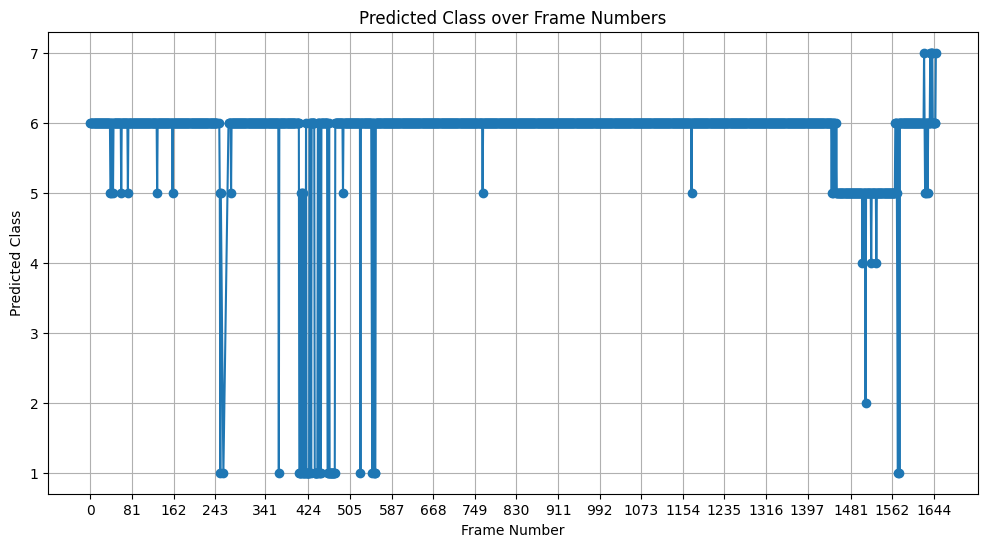

In [77]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from itertools import groupby
from operator import itemgetter

# Step 1: Load Predictions
predictions_df = pd.read_csv('predictions.csv')

# Ensure the DataFrame is sorted by 'frame_number'
predictions_df = predictions_df.sort_values('frame_number').reset_index(drop=True)

# Step 2: Identify Class Ranges
# This function groups consecutive frames with the same predicted class
def get_class_ranges(df):
    ranges = []
    for class_label, group in groupby(enumerate(df['predicted_class']), key=lambda x: x[1]):
        group = list(group)
        start_idx = group[0][0]
        end_idx = group[-1][0]
        frame_start = df.loc[start_idx, 'frame_number']
        frame_end = df.loc[end_idx, 'frame_number']
        ranges.append({
            'predicted_class': class_label,
            'frame_start': frame_start,
            'frame_end': frame_end
        })
    return ranges

# Get the class ranges
class_ranges = get_class_ranges(predictions_df)

# Step 3: Print Numerical Ranges
print("Predicted Class Ranges:")
for item in class_ranges:
    print(f"Class {item['predicted_class']}: Frames {item['frame_start']} to {item['frame_end']}")

# Step 4: Plot Predictions
plt.figure(figsize=(12, 6))
plt.plot(predictions_df['frame_number'], predictions_df['predicted_class'], marker='o', linestyle='-')
plt.title('Predicted Class over Frame Numbers')
plt.xlabel('Frame Number')
plt.ylabel('Predicted Class')
plt.grid(True)
plt.xticks(predictions_df['frame_number'][::max(1, len(predictions_df)//20)])  # Adjust x-ticks for readability
plt.yticks(range(predictions_df['predicted_class'].min(), predictions_df['predicted_class'].max()+1))
plt.show()


In [206]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SVMSMOTE
from collections import Counter
import joblib

# Load and preprocess data
df = pd.read_csv('/kaggle/input/new-data-2/new_data_2.csv')  # Replace with the path to your data file

# Separate features and target
X = df.drop(columns=['target']).values.astype(np.float32)
y = df['target'].values

# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)
joblib.dump(scaler, 'scaler.save')  # Save scaler for later use

# Check current class distribution
class_counts = Counter(y)
print("Original class distribution:", class_counts)

# Define target class counts to increase size by 30%
sampling_strategy = {cls: int(count * 1.3) for cls, count in class_counts.items()}
print("Target class distribution with 30% increase:", sampling_strategy)

# Apply SVMSMOTE to generate synthetic data
svm_smote = SVMSMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_synthetic, y_synthetic = svm_smote.fit_resample(X, y)

# Combine original and synthetic data
X_augmented = np.vstack([X, X_synthetic])
y_augmented = np.concatenate([y, y_synthetic])

# Split augmented data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=42)

# Create custom Dataset
class SimpleDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader for train and test sets
train_dataset = SimpleDataset(X_train, y_train)
test_dataset = SimpleDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Original class distribution: Counter({0: 1116, 9: 550, 2: 537, 1: 528, 8: 523, 3: 523, 4: 499, 6: 454, 7: 424, 5: 375})
Target class distribution with 30% increase: {1: 686, 9: 715, 6: 590, 0: 1450, 8: 679, 7: 551, 2: 698, 4: 648, 3: 679, 5: 487}


In [207]:
# Define the MLP Model
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size, dropout_rate=0.3):
        super(MLPModel, self).__init__()
        layers = []
        in_features = input_size
        
        # Add hidden layers with ReLU and dropout
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            in_features = hidden_size
        
        # Output layer with the number of classes (output_size)
        layers.append(nn.Linear(in_features, output_size))
        
        # Define the entire network
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Model parameters
input_size = X_train.shape[1]
hidden_layers = [1024, 512, 256, 128, 64]
output_size = len(np.unique(y))  # Number of classes
dropout_rate = 0.3

# Instantiate the model, loss function, and optimizer
model = MLPModel(input_size, hidden_layers, output_size, dropout_rate)
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
def train_model(model, train_loader, criterion, optimizer, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        all_preds = []
        all_labels = []
        
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Collect predictions for accuracy
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(y_batch.numpy())
        
        # Calculate accuracy and print metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = accuracy_score(all_labels, all_preds)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(y_batch.numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1:.4f}")

# Save the model
torch.save(model.state_dict(), 'mlp_model.pth')

# Train and evaluate
train_model(model, train_loader, criterion, optimizer, num_epochs=20)
evaluate_model(model, test_loader)

# ---------------------------------------------------
# Testing Function
# ---------------------------------------------------

def test_model(test_df, model, scaler):
    """
    Test the trained model on new data and output predictions with frame numbers.

    Parameters:
    test_df (pd.DataFrame): The test DataFrame containing features and 'frame_number'.
    model (nn.Module): The trained MLP model.
    scaler (StandardScaler): Scaler used during training to normalize data.
    """
    model.eval()
    
    # Features are from 'x0' to 'x34'; exclude 'frame_number'
    feature_columns = [col for col in test_df.columns if col != 'frame_number']
    
    # Scale the features
    test_df_scaled = test_df.copy()
    test_df_scaled[feature_columns] = scaler.transform(test_df[feature_columns])

    # Extract features and frame numbers
    features = test_df_scaled[feature_columns].values.astype(np.float32)
    frame_numbers = test_df_scaled['frame_number'].values

    # Convert features to tensor
    test_sequences = torch.tensor(features, dtype=torch.float32)

    # Make predictions
    all_predictions = []
    with torch.no_grad():
        outputs = model(test_sequences)
        _, predicted = torch.max(outputs, 1)  # Get the predicted classes
        all_predictions = predicted.numpy()

    # Create a DataFrame with frame numbers and predicted classes
    predictions_df = pd.DataFrame({
        'frame_number': frame_numbers,
        'predicted_class': all_predictions
    })

    # Save predictions to CSV
    predictions_df.to_csv('predictions.csv', index=False)
    print("Predictions saved to 'predictions.csv'")

# Example usage:
test_df = pd.read_csv('/kaggle/input/data-test/data_test.csv')  # Replace with your test data file path
test_model(test_df, model, scaler)

Epoch [1/20], Loss: 1.1300, Accuracy: 0.5593
Epoch [2/20], Loss: 0.7177, Accuracy: 0.7087
Epoch [3/20], Loss: 0.6421, Accuracy: 0.7409


KeyboardInterrupt: 